In [1]:
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%time
MIN_MATCH_COUNT = 10
img1 = cv.imread(r"E:\twibot\twinit-dataset\debug\card5.jpg", 0)
img2 = cv.imread(r"E:\twibot\twinit-dataset\debug\card12.jpg", 0)

CPU times: total: 0 ns
Wall time: 61.2 ms


In [13]:
# img1 = cv.resize(img1, (128, 128))
# img2 = cv.resize(img2, (128, 128))

In [3]:
# Initiate SIFT detector
sift = cv.SIFT_create()

In [4]:
%%time
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

CPU times: total: 93.8 ms
Wall time: 49 ms


In [5]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [6]:
%%time
flann = cv.FlannBasedMatcher(index_params, search_params)

CPU times: total: 15.6 ms
Wall time: 5.01 ms


In [7]:
%%time
matches = flann.knnMatch(des1,des2,k=2)

CPU times: total: 0 ns
Wall time: 16 ms


In [8]:
%%time
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(len(good))

1
CPU times: total: 0 ns
Wall time: 3 ms


In [9]:
%%time
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

Not enough matches are found - 1/10
CPU times: total: 0 ns
Wall time: 0 ns


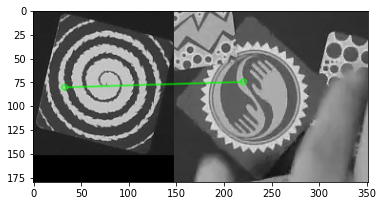

(<matplotlib.image.AxesImage at 0x1e13d0e8820>, None)

In [10]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()